In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel
from templates import gliomapublic_autoenc
from templates_cls import *
from experiment_classifier import ClsModel
from experiment import LitModel
import torch
from dataset import ImageDataset,FFHQlmdb
import matplotlib.pyplot as plt
from mri_utils import *
import random
import numpy as np

In [6]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device)


2023-01-20 13:42:53,451 - Created a temporary directory at /tmp/tmpez4_qr4l
2023-01-20 13:42:53,452 - Writing /tmp/tmpez4_qr4l/_remote_module_non_scriptable.py


Global seed set to 0


Model params: 160.69 M


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/ffhq256_autoenc/last.ckpt'

In [ ]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                   map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False)
cls_model.to(device)
print()

In [ ]:
# data = conf.make_dataset()
# batch = data[10]['img'][None]

In [11]:
data = ImageDataset('imgs_align',
                    image_size=conf.img_size,
                    exts=['jpg', 'JPG', 'png'],
                    do_augment=False)
data = FFHQlmdb(path="./datasets/ffhq256.lmdb",
                image_size=256,
                do_augment=False)
"""
batch = torch.as_tensor(
    np.asarray(
        Image.open(
            os.path.expanduser("/home/home/daniel/Scholz Daniel (1).JPG")))
)[None].float().div(128).sub(1).permute(0, 3, 1, 2)
"""
# centre crop batch
x_mid = batch.shape[2] // 2
y_mid = batch.shape[3] // 2
offset = 800
batch = batch[:, :, x_mid - offset:x_mid + offset,
              y_mid - offset:y_mid + offset]
# make square 
batch = F.interpolate(batch, size=(256, 256), mode='bicubic').clamp(-1, 1)
# batch = data[2]['img'][None]

Error: ./datasets/ffhq256.lmdb: No such file or directory

In [ ]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

In [ ]:
print(CelebAttrDataset.id_to_cls)

In [12]:
cls_id = CelebAttrDataset.cls_to_id['Wavy_Hair']

NameError: name 'CelebAttrDataset' is not defined

In [ ]:
# create new conditional vector conditioned on the class
cls_strength = .3
cond2 = cls_model.normalize(cond)
clf_hyperplane = F.normalize(cls_model.classifier.weight[cls_id][None, :],
                             dim=1)
cond2 = cond2 +  cls_strength * math.sqrt(512) * clf_hyperplane
cond2 = cls_model.denormalize(cond2)

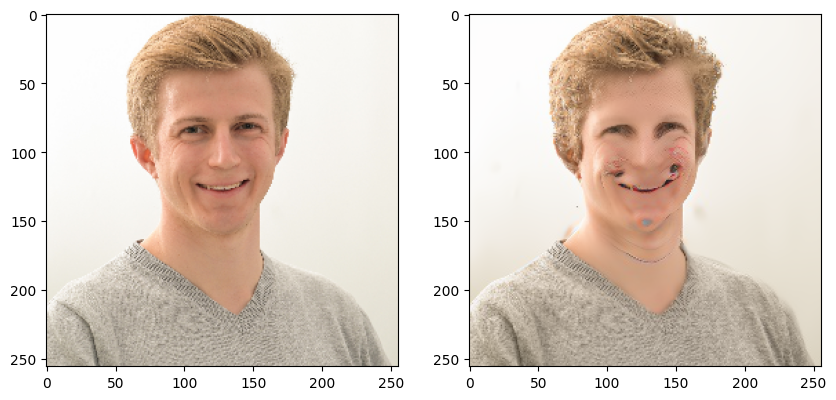

In [45]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, cond2, T=100)
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())
plt.savefig('imgs_manipulated/compare.png')

In [34]:
from torchvision.utils import save_image

save_image(img[0], 'imgs_manipulated/output.png')